In [1]:
import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from numba import jit
import librosa, librosa.display
import pandas as pd
import IPython.display as ipd
import sys
sys.path.append('..')
import libfmp.c2
%matplotlib inline

## STFT e Frequências de Tom
Assumindo que as musicas que estamos lidando está com a mesma "escala" podemos representa-las num grafico que nos mostra a distribuição da energia do sinal em cada Tom, isso é chamado de espectograma.
A ideia principal do espectrograma de frequência logarítmica é redefinir o eixo de frequência para corresponder à distribuição de frequência espaçada de forma logarítmica da escala igual. (Já que numa escala normal a distancia de uma nota a sua próxima cresce de forma exponencial).
Identificando os Tons com os números de nota MIDI (onde a nota A4 corresponde ao número de nota MIDI $p=69$ ), as frequências centrais são dadas por:
$$F_{pitch}​(p)=2^{(p−69)/12}⋅440$$

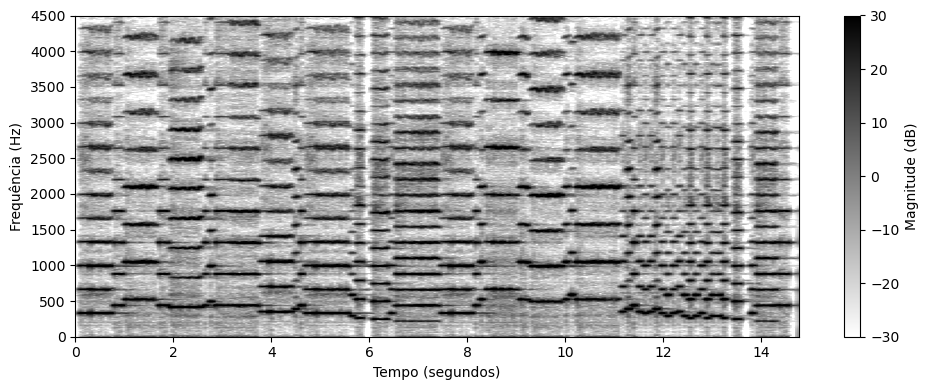

In [2]:
#fn_wav = os.path.join('FMP_C3_F03.mp3')
fn_wav = os.path.join('MIDI_JICTAC.wav')
Fs = 22050 # taxa de amostragem

x, Fs = librosa.load(fn_wav, sr=Fs)
# parâmetros da STFT
N = 4096  # Tamanho da FFT
H = 1024  # Tamanho do salto (Hop size)
X, T_coef, F_coef = libfmp.c2.stft_convention_fmp(x, Fs, N, H)

# Calculando o Espectrograma
Y = np.abs(X) ** 2 

# Aplicar escala logarítmica e plotar o espectrograma:
fig = plt.figure(figsize=(10, 4))
eps = np.finfo(float).eps
plt.imshow(10 * np.log10(eps + Y), origin='lower', aspect='auto', cmap='gray_r', 
           extent=[T_coef[0], T_coef[-1], F_coef[0], F_coef[-1]])

plt.clim([-30, 30])
plt.ylim([0, 4500])
plt.xlabel('Tempo (segundos)')
plt.ylabel('Frequência (Hz)')
cbar = plt.colorbar()
cbar.set_label('Magnitude (dB)')
plt.tight_layout()
rect = matplotlib.patches.Rectangle((29.3, 0.5), 1.2, 4490, linewidth=3, 
                                    edgecolor='r', facecolor='none')
plt.gca().add_patch(rect);

## logaritimo de frequência Pooling

O logaritimo de frequência Pooling (Logarithmic Frequency Pooling) motiva o uso de uma representação tempo-frequência com um eixo de frequência logarítmico rotulado pelas alturas da escala temperada igual. Para derivar tal representação a partir de uma representação de espectrograma dada, a ideia básica é atribuir cada coeficiente espectral $X(n, k)$ à altura com uma frequência central que está mais próxima da frequência $F_{coef}(k)$. Mais precisamente, definimos para cada altura $p ∈ [0:127]$ o conjunto:
$$P(p) := {k: F_{pitch}(p-0.5) ≤ F_{coef}(k) < F_{pitch}(p+0.5)}$$
A faixa de frequência coberta pelo conjunto $P(p)$ depende da frequência de maneira logarítmica. Definimos a largura de banda $BW(p)$ da altura $p$ por:
$$BW(p) := F_{pitch}(p+0.5) - F_{pitch}(p-0.5)$$
A largura de banda $BW(p)$ torna-se menor para alturas decrescentes. Em particular, ela é reduzida pela metade ao diminuir a altura por uma oitava. Por exemplo, para a altura de pitch MIDI $p = 66$ temos uma largura de banda de aproximadamente $21.4 Hz$, enquanto para $p = 54$ a largura de banda fica abaixo de $10.7 Hz$. A tabela a seguir mostra várias notas e seus números de nota MIDI $p$, frequência central $F_{pitch}(p)$, frequências de corte $F_{pitch}(p-0.5)$ e $F_{pitch}(p+0.5)$, e largura de banda $BW(p)$.

In [3]:
def note_name(p):
    """ Retorna o nome da nota com base no tom
    Args:
        p (int): Valor do tom
    Returns:
        name (str): Nome da nota """
    chroma = ['A', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G',
              'G#']
    name = chroma[(p - 69) % 12] + str(p // 12 - 1)
    return name

# Função para calcular a frequência do tom com base no valor MIDI
f_pitch = lambda p: 440 * 2 ** ((p - 69) / 12)
   
# Lista para armazenar informações sobre as notas:
note_infos = []

# Loop pelos valores MIDI dos tons de 60 a 72:
for p in range(60, 73):
    name = note_name(p)

    # Calcula as frequências para a nota e suas faixas inferior e superior
    p_pitch = f_pitch(p)
    p_pitch_lower = f_pitch(p - 0.5)
    p_pitch_upper = f_pitch(p + 0.5)
    
    # Calcula a largura de banda
    bw = p_pitch_upper - p_pitch_lower

    # Adiciona informações sobre a nota à lista
    note_infos.append([name, p, p_pitch, p_pitch_lower, p_pitch_upper, bw])

# Criar um DataFrame do Pandas a partir da lista com nomes de colunas especificados
df = pd.DataFrame(note_infos, columns=['Note', 'p', 'Fpitch(p)', 'Fpitch(p-0.5)', 'Fpitch(p+0.5)', 'BW(p)'])

# Converter o DataFrame para uma tabela HTML, excluindo o índice e formatando números de ponto flutuante
html = df.to_html(index=False, float_format='%.2f')

# Adicionar um atributo de estilo à tabela HTML para definir sua largura como 80%
html = html.replace('<table', '<table style="width: 80%"')
ipd.HTML(html)

Note,p,Fpitch(p),Fpitch(p-0.5),Fpitch(p+0.5),BW(p)
C4,60,261.63,254.18,269.29,15.11
C#4,61,277.18,269.29,285.30,16.01
D4,62,293.66,285.30,302.27,16.97
D#4,63,311.13,302.27,320.24,17.97
E4,64,329.63,320.24,339.29,19.04
F4,65,349.23,339.29,359.46,20.18
F#4,66,369.99,359.46,380.84,21.37
G4,67,392.00,380.84,403.48,22.65
G#4,68,415.30,403.48,427.47,23.99
A4,69,440.00,427.47,452.89,25.42


## Espectrograma de Frequência Logarítmica:
Com base nos conjuntos $P(p)$, obtemos um espectrograma de frequência Logarítmica: $YLF: \mathbb{Z} \times [0:127]$ usando um procedimento simples de pooling:
$$YLF(n, p) := \sum_{k \in P(p)} |X(n, k)|^2.$$

Por meio desse procedimento, o eixo de frequência é particionado de maneira logarítmica e rotulado linearmente de acordo com os tons MIDI. O exemplo a seguir mostra o espectrograma de log-frequência resultante, onde as notas tocadas na escala cromática agora aparecem de maneira linearmente crescente.

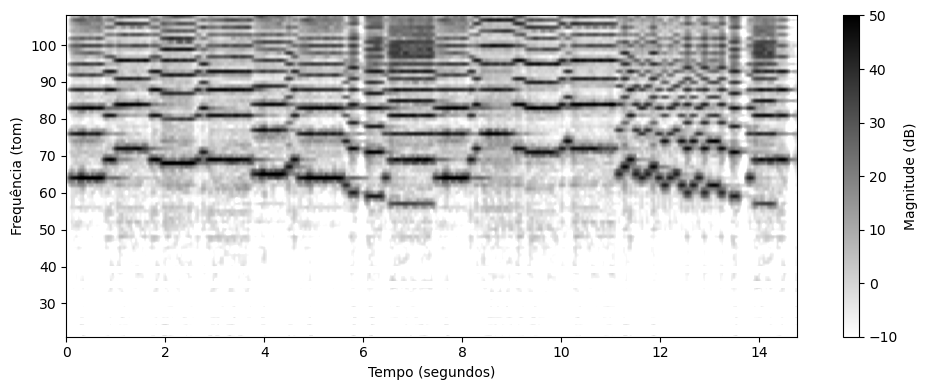

In [4]:
@jit(nopython=True)
def f_pitch(p, pitch_ref=69, freq_ref=440.0):
    """ Calcula a frequência central de um pitch MIDI
    Args:
        p (float): Valor(es) do pitch MIDI
        pitch_ref (float): Pitch de referência (padrão: 69)
        freq_ref (float): Frequência do pitch de referência (padrão: 440.0)
    Returns:
        freqs (float): Valor(es) da frequência """
    return 2 ** ((p - pitch_ref) / 12) * freq_ref

@jit(nopython=True)
def pool_pitch(p, Fs, N, pitch_ref=69, freq_ref=440.0):
    """Calcula o conjunto de índices de frequência associados a um dado pitch
    Args:
        p (float): Valor do pitch MIDI
        Fs (scalar): Taxa de amostragem
        N (int): Tamanho da janela da transformada de Fourier
        pitch_ref (float): Pitch de referência (padrão: 69)
        freq_ref (float): Frequência do pitch de referência (padrão: 440.0)
    Returns:
        k (np.ndarray): Conjunto de índices de frequência """
    lower = f_pitch(p - 0.5, pitch_ref, freq_ref)
    upper = f_pitch(p + 0.5, pitch_ref, freq_ref)
    k = np.arange(N // 2 + 1)
    k_freq = k * Fs / N
    mask = np.logical_and(lower <= k_freq, k_freq < upper)
    return k[mask]

@jit(nopython=True)
def compute_spec_log_freq(Y, Fs, N):
    """Calcula um espectrograma em frequência logarítmica
    Args:
        Y (np.ndarray): Espectrograma de magnitude ou potência
        Fs (scalar): Taxa de amostragem
        N (int): Tamanho da janela da transformada de Fourier
    Returns:
        Y_LF (np.ndarray): Espectrograma em frequência logarítmica
        F_coef_pitch (np.ndarray): Valores de pitch
    """
    Y_LF = np.zeros((128, Y.shape[1]))
    for p in range(128):
        k = pool_pitch(p, Fs, N)
        Y_LF[p, :] = Y[k, :].sum(axis=0)
    F_coef_pitch = np.arange(128)
    return Y_LF, F_coef_pitch

# Calcular o espectrograma em frequência logarítmica:
Y_LF, F_coef_pitch = compute_spec_log_freq(Y, Fs, N)        

# Plotar o espectrograma em frequência logarítmica:
fig = plt.figure(figsize=(10, 4))
plt.imshow(10 * np.log10(eps + Y_LF), origin='lower', aspect='auto', cmap='gray_r', 
           extent=[T_coef[0], T_coef[-1], 0, 127])

plt.clim([-10, 50])
plt.ylim([21, 108])
plt.xlabel('Tempo (segundos)')
plt.ylabel('Frequência (tom)')
cbar = plt.colorbar()
cbar.set_label('Magnitude (dB)')
plt.tight_layout()
rect = matplotlib.patches.Rectangle((29.3, 21), 1.2, 86.5, linewidth=3, edgecolor='r', facecolor='none')
plt.gca().add_patch(rect);


Observando o espectrograma, é possível fazer algumas observações interessantes:

1. Como tendência geral, os sons para notas mais agudas possuem um espectro harmônico mais limpo do que os para notas mais graves. Para notas mais graves, a energia do sinal frequentemente está contida nos harmônicos mais altos, enquanto o ouvinte ainda pode ter a percepção de um som de baixa frequência.

2. As listras verticais (ao longo do eixo de frequência) mostradas pelo espectrograma indicam que parte da energia do sinal está distribuída por grandes partes do espectro. A principal razão para a dispersão de energia ocorre devido às inarmonias do som do piano causadas pelo impacto das teclas (ruído mecânico), bem como efeitos transitórios e de ressonância.

3. Além disso, o conteúdo de frequência de um som depende da resposta de frequência do microfone. Por exemplo, o microfone pode capturar apenas frequências acima de um certo limite, como no caso do nosso exemplo de áudio. Isso também pode explicar por que praticamente não há energia visível nas frequências fundamentais das notas A0( $p = 21$ ) a B0 $( p = 32 )$.

Além das propriedades acústicas, há outra razão para a representação relativamente fraca de notas graves ao usar a estratégia de pooling com base em um STFT discreto. Enquanto o STFT discreto introduz uma amostragem linear do eixo de frequência, a largura de banda usada na estratégia de pooling depende da frequência de maneira logarítmica. Como resultado, o conjunto $P(p)$ pode conter apenas alguns coeficientes espectrais ou até mesmo estar vazio para valores pequenos de $p$ (razão das listras brancas horizontais na figura acima).


In [5]:
print('Taxa de amostragem: Fs = ', Fs)
print('Tamanho da janela: N = ', N)
print('Resolução de frequência da STFT (em Hz): Fs/N = %4.2f' % (Fs / N))

# Imprimir os conjuntos de índices de frequência para determinados pitches
for p in [76, 64, 52, 40, 39, 38]:
    print('Conjunto P(%d) = %s' % (p, pool_pitch(p, Fs, N)))

Taxa de amostragem: Fs =  22050
Tamanho da janela: N =  4096
Resolução de frequência da STFT (em Hz): Fs/N = 5.38
Conjunto P(76) = [119 120 121 122 123 124 125 126]
Conjunto P(64) = [60 61 62 63]
Conjunto P(52) = [30 31]
Conjunto P(40) = [15]
Conjunto P(39) = []
Conjunto P(38) = [14]


## Cromagrama

Uma estratégia para aumentar a robustez do Espectrograma de frequência-log a variações de timbre e instrumentação.
A ideia principal é combinar adequadamente bandas de Toms correspondentes a alturas que diferem por uma ou várias oitavas. 
A percepção humana de altura é periódica no sentido de que dois tons são percebidos como semelhantes em "cor" (tendo um papel harmônico semelhante) se diferirem por uma oitava. Com base nessa observação, um Tom pode ser separado em dois componentes, denominados altura de tom e croma. A altura de tom refere-se ao número da oitava e o [croma ao respectivo atributo de soletração de Tom contido no conjunto]

$\{C, C\sharp, D, D\sharp, \ldots, B\}$.

Enumerando os valores de croma, identificamos este conjunto com $[0:11]$, onde $0$ refere-se ao croma $C$ , $1$ a $C\sharp$ , e assim por diante. Uma classe de Tom é definida como o conjunto de todos os Toms que compartilham o mesmo croma. Por exemplo, a classe de Tom correspondente ao croma $C$ é o conjunto $\{\ldots, C_0, C_1, C_2, C_3, \ldots\}$ consistindo em todos os Tons separados por um número inteiro de oitavas. Para simplicidade, usamos os termos croma e classe de Tom de forma intercambiável.
A ideia principal das características de croma é agregar todas as informações espectrais relacionadas a uma determinada classe de Tom em um único coeficiente. Dado um espectrograma de frequência-log baseado em tom $YLF: \mathbb{Z} \times [0:127] \rightarrow \mathbb{R}_{\geq 0}$ uma representação de croma ou cromagrama $Z \times [0:11] \rightarrow \mathbb{R}_{\geq 0}$ pode ser derivada somando todos os coeficientes de Tom que pertencem ao mesmo croma: $$C(n, c) := \sum_{p \in [0:127]: \text{mod}(p, 12) = c} YLF(n, p)$$ para $c \in [0:11]$. Continuando nosso exemplo, o exemplo a seguir gera um cromagrama da escala cromática, onde a natureza cíclica das características de croma se torna evidente. Devido à equivalência de oitava, as notas crescentes da escala cromática são "enroladas" em torno do eixo de croma. Assim como o espectrograma de log-frequência, o cromagrama resultante do exemplo de áudio considerado é bastante ruidoso, especialmente para as notas mais baixas. Além disso, devido à presença de harmônicos mais altos, a energia é tipicamente distribuída por várias bandas de croma mesmo ao tocar uma única nota de cada vez. Por exemplo, ao tocar a nota C3, o terceiro harmônico corresponde a G4 e o quinto harmônico a E5. Portanto, ao tocar a nota C3 no piano, não apenas a banda de croma $ C $, mas também as bandas de croma $ G $ e $ E $ contêm uma parte substancial da energia do sinal.

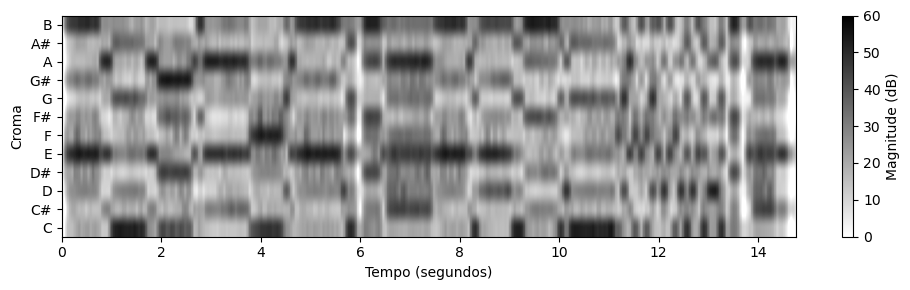

In [6]:
@jit(nopython=True)
def compute_chromagram(Y_LF):
    """Calcula um cromagrama
    Args:
        Y_LF (np.ndarray): Espectrograma com frequência logarítmica
    Returns:
        C (np.ndarray): Cromagrama """
    C = np.zeros((12, Y_LF.shape[1]))
    p = np.arange(128)
    for c in range(12):
        mask = (p % 12) == c
        C[c, :] = Y_LF[mask, :].sum(axis=0)
    return C

C = compute_chromagram(Y_LF)

fig = plt.figure(figsize=(10, 3))
chroma_label = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
plt.imshow(10 * np.log10(eps + C), origin='lower', aspect='auto', cmap='gray_r', extent=[T_coef[0], T_coef[-1], 0, 12])
plt.clim([0, 60])
plt.xlabel('Tempo (segundos)')
plt.ylabel('Croma')
cbar = plt.colorbar()
cbar.set_label('Magnitude (dB)')
plt.yticks(np.arange(12) + 0.5, chroma_label)
plt.tight_layout()
rect = matplotlib.patches.Rectangle((29.3, 0.0), 1.2, 12, linewidth=3, edgecolor='r', facecolor='none')
plt.gca().add_patch(rect);

### Função de Compressão

No processamento de sinais musicais, o problema com representações como um espectrograma ou cromagrama é que seus valores possuem uma ampla faixa dinâmica. Como resultado, valores pequenos, mas ainda relevantes, podem ser dominados ou obscurecidos por valores grandes. Portanto, muitas vezes é utilizado uma escala em decibéis, onde a ideia é equilibrar essa discrepância reduzindo a diferença entre valores grandes e pequenos com o efeito de realçar os valores pequenos. Mais genericamente, pode-se aplicar outros tipos de funções baseadas em logaritmos, um passo frequentemente referido como compressão logarítmica.

Seja  γ ∈ ℝ⁺  uma constante positiva, então definimos uma função  Γ₍ᵧ₎: ℝ⁺ → ℝ⁺  por

$$ Γᵧ(v) := \log(1 + γ ⋅ v) $$

para algum valor positivo  v ∈ ℝ⁺ . Em oposição à função \(dB\), a função  Γᵧ  resulta em um valor positivo  Γᵧ(v)  para qualquer valor positivo  v ∈ ℝ⁺ . O grau de compressão pode ser ajustado pela constante  γ : quanto maior  γ , maior será a compressão resultante.

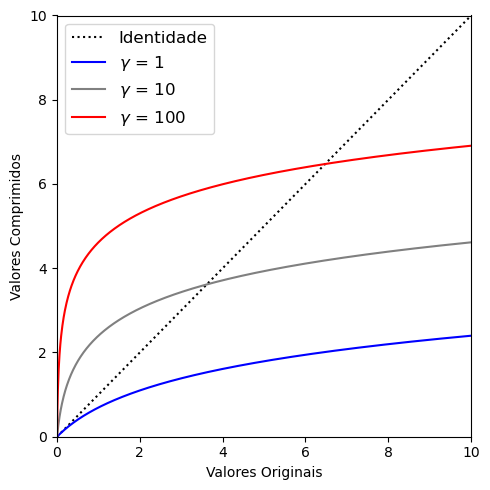

In [7]:
@jit(nopython=True)
def log_compression(v, gamma=1.0):
    """Realiza compressão logarítmica em um valor ou array
    Args:
        v (float or np.ndarray): Valor ou array
        gamma (float): Fator de compressão (Valor padrão = 1.0)
    Returns:
        v_compressed (float or np.ndarray): Valor ou array comprimido """
    return np.log(1 + gamma * v)

# Cria um array de valores para teste
v = np.arange(1001) / 100

plt.figure(figsize=(5, 5))
plt.plot(v, v, color='black', linestyle=':', label='Identidade')

plt.plot(v, log_compression(v, gamma=1), color='blue', label='$\gamma$ = 1')
plt.plot(v, log_compression(v, gamma=10), color='gray', label='$\gamma$ = 10')
plt.plot(v, log_compression(v, gamma=100), color='red', label='$\gamma$ = 100')

plt.xlabel('Valores Originais')
plt.ylabel('Valores Comprimidos')
plt.xlim([v[0], v[-1]])
plt.ylim([v[0], v[-1]])
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()

# Espectrograma Comprimido

Para uma representação com valores positivos, como um espectrograma, obtém-se uma versão comprimida aplicando a função  $Γᵧ$  a cada um dos valores. Por exemplo, para um espectrograma  $Y$ , a versão comprimida é a concatenação  $Γᵧ ∘ Y$  definida por:

$$(\Gammaᵧ ∘ Y)(n, k) := \log(1 + ᵧ ⋅ Y(n, k))$$

com  $n$  sendo o parâmetro do intervalo de tempo e  $k$  o parâmetro do bin de frequência. Uma escolha adequada de  $γ$  depende muito das características dos dados e da aplicação em questão. Em particular, na presença de ruído, é necessário encontrar um bom equilíbrio entre realçar os componentes de sinal fracos, mas relevantes, e não amplificar muito os componentes indesejados de ruído.

Como exemplo ilustrativo, consideramos uma gravação da nota C4 tocada em um piano. A figura a seguir mostra o espectrograma resultante, bem como versões comprimidas usando diferentes constantes  $γ$.

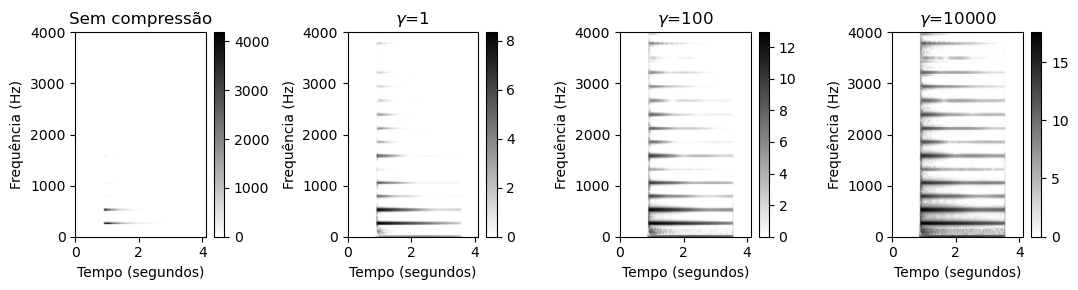

In [8]:
x, Fs = librosa.load(os.path.join('FMP_C3_NoteC4_Piano.wav'))

#STFT
N = 1024
H = 512
X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hann', pad_mode='constant', center=True)

# Calcula os coeficientes de tempo e frequência
T_coef = np.arange(X.shape[1]) * H / Fs
K = N // 2
F_coef = np.arange(K + 1) * Fs / N

# Calcular a magnitude ao quadrado
Y = np.abs(X) ** 2

plt.figure(figsize=(11, 3))

# Configurar parâmetros para compressão logarítmica
gamma_set = [0, 1, 100, 10000]
M = len(gamma_set)

# Iterar sobre diferentes valores de gamma e plotar as imagens resultantes
for m in range(M):
    ax = plt.subplot(1, M, m + 1)
    gamma = gamma_set[m]
    if gamma == 0:
        Y_compressed = Y
        title = 'Sem compressão'
    else:
        # Aplicar compressão logarítmica
        Y_compressed = log_compression(Y, gamma=gamma)
        title = '$\gamma$=%d' % gamma
    
    plt.imshow(Y_compressed, cmap='gray_r', aspect='auto', origin='lower', extent=[T_coef[0], T_coef[-1], F_coef[0], F_coef[-1]])
    plt.xlabel('Tempo (segundos)')
    plt.ylim([0, 4000])
    plt.clim([0, Y_compressed.max()])
    plt.ylabel('Frequência (Hz)')
    plt.colorbar()
    plt.title(title)
plt.tight_layout()


Embora os parciais (as linhas horizontais) sejam praticamente invisíveis no espectrograma original, eles claramente aparecem nas versões comprimidas. Além disso, a transição da nota (a linha vertical na posição do tempo  $t = 0.9$ ) surge ao aumentar a constante  $γ$ . Como desvantagem, componentes de som semelhantes a ruído também são realçados ao comprimir o espectrograma. Uma escolha adequada de  $γ$  depende muito das características dos dados e da aplicação em questão. Em particular, na presença de ruído, é necessário encontrar um bom equilíbrio entre realçar os componentes de sinal fracos, mas relevantes, e não amplificar muito os componentes indesejados de ruído.

# Cromagrama Comprimido

A seguir, consideramos um cromagrama  $C$  e sua versão comprimida  $Γᵧ ∘ C$  definida por:

$$(\Gammaᵧ ∘ C)(n, c) := \log(1 + ᵧ ⋅ C(n, c)).$$

Como exemplo, consideramos uma gravação de um piano tocando uma escala de Dó maior.

A figura a seguir mostra um cromagrama, bem como versões comprimidas usando diferentes constantes $γ$.

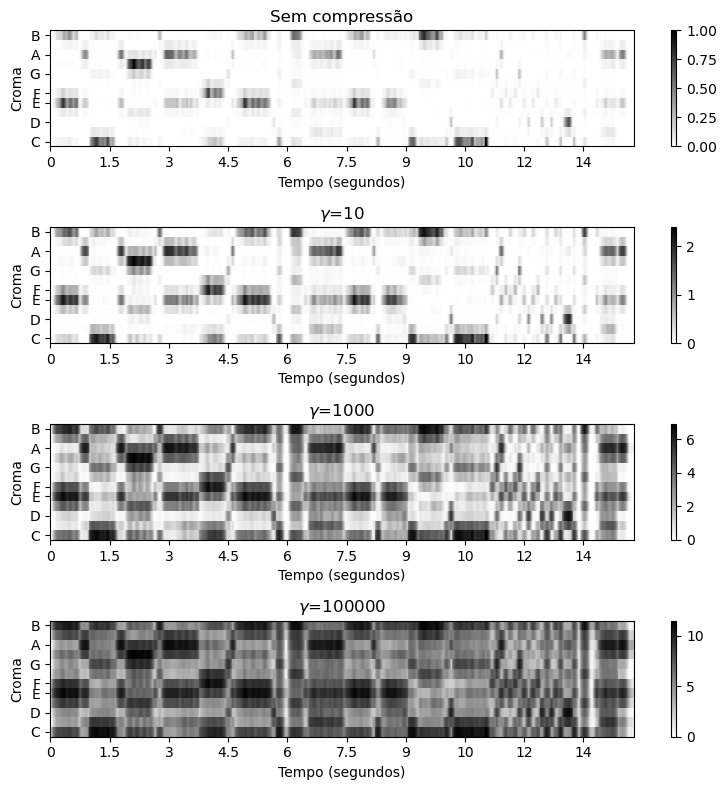

In [9]:
#fn_wav = os.path.join('FMP_C3_F08_C-major-scale_pause.wav')
fn_wav = os.path.join('MIDI_JICTAC.wav')
Fs = 22050
x, Fs = librosa.load(fn_wav, sr=Fs)

# STFT
N = 4096
H = 512
C = librosa.feature.chroma_stft(y=x, sr=Fs, tuning=0, norm=None, hop_length=H, n_fft=N)
C = C / C.max()

plt.figure(figsize=(8, 8))

gamma_set = [0, 10, 1000, 100000]
M = len(gamma_set)
for m in range(M):
    ax = plt.subplot(M, 1, m + 1)
    gamma = gamma_set[m]
    if gamma == 0:
        C_compressed = C
        title = 'Sem compressão'
    else:
        # Aplicar compressão logarítmica
        C_compressed = log_compression(C, gamma=gamma)
        title = '$\gamma$=%d' % gamma
    
    librosa.display.specshow(C_compressed, x_axis='time', 
                             y_axis='chroma', cmap='gray_r', sr=Fs, hop_length=H)
    plt.xlabel('Tempo (segundos)')
    plt.ylabel('Croma')
    plt.clim([0, np.max(C_compressed)])
    plt.title(title)
    plt.colorbar()
plt.tight_layout()